In [3]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Dataset.csv')

In [5]:
df.apply(lambda x : len(x.unique()))


Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum()


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
cat_col = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        cat_col.append(x)
display(cat_col)

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [10]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')

In [11]:
display(cat_col)


['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [12]:
for col in cat_col:
    print(col,len(df[col].unique()))

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


In [13]:
for col in cat_col:
    print(col)
    print(df[col].value_counts(),'\n')
    print('-'*55)

Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64 

-------------------------------------------------------
Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Size
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Location_Type
Outlet_Location_Type
Tier 3    3350
Tier 2  

In [14]:
miss_bool = df['Item_Weight'].isnull()
Item_Weight_Null = df[df['Item_Weight'].isnull()]
display(Item_Weight_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [15]:
Item_Weight_Null['Item_Identifier'].value_counts()


Item_Identifier
FDC14    2
FDV20    2
FDH10    2
FDW39    2
FDN34    2
        ..
FDS32    1
FDL10    1
FDT24    1
FDY28    1
FDC37    1
Name: count, Length: 1142, dtype: int64

In [16]:
Item_Weight_Mean = df.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
display(Item_Weight_Mean)

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [17]:
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in Item_Weight_Mean:
            df['Item_Weight'][i] = Item_Weight_Mean.loc[item]['Item_Weight']
        else:
            df['Item_Weight'][i] = np.mean(df['Item_Weight'])

In [18]:
df['Item_Weight'].isna().sum()


np.int64(0)

In [19]:
df['Outlet_Size'].value_counts()


Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [20]:
df['Outlet_Size'].isnull().sum()


np.int64(2410)

In [21]:
Outlet_Size_Null = df[df['Outlet_Size'].isna()]
display(Outlet_Size_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [22]:
Outlet_Size_Null['Outlet_Type'].value_counts()


Outlet_Type
Supermarket Type1    1855
Grocery Store         555
Name: count, dtype: int64

In [23]:
df.groupby(['Outlet_Type','Outlet_Size']).agg({'Outlet_Type':[np.size]})


Outlet_Type
                                     size
Outlet_Type       Outlet_Size            
Grocery Store     Small               528
Supermarket Type1 High                932
                  Medium              930
                  Small              1860
Supermarket Type2 Medium              928
Supermarket Type3 Medium              935

In [24]:
Outlet_Size_Mode = df.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x : x.mode()[0]))
display(Outlet_Size_Mode)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [25]:
miss_bool = df['Outlet_Size'].isna()
df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x : Outlet_Size_Mode[x])

In [26]:
df['Outlet_Size'].isna().sum()

np.int64(0)

In [27]:
df.isna().sum()


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [28]:
sum(df['Item_Visibility'] == 0)


526

In [29]:
df.loc[:,'Item_Visibility'].replace([0],[df['Item_Visibility'].mean()],inplace = True)


In [30]:
sum(df['Item_Visibility'] == 0)


0

In [31]:
df['Item_Fat_Content'].value_counts()


Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [32]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF' : 'Low Fat', 'low fat' : 'Low Fat', 'reg' : 'Regular'})
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [33]:
df['New_Item_Type'] = df['Item_Identifier'].apply(lambda x : x[:2])
df['New_Item_Type'].value_counts()

New_Item_Type
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

In [34]:
df['New_Item_Type'] = df['New_Item_Type'].replace({'FD' : 'Food', 'NC' : 'Non-Consumables', 'DR' : 'Drinks'})
df['New_Item_Type'].value_counts()

New_Item_Type
Food               6125
Non-Consumables    1599
Drinks              799
Name: count, dtype: int64

In [35]:
df.groupby(['New_Item_Type','Item_Fat_Content']).agg({'Outlet_Type':[np.size]})


Outlet_Type
                                        size
New_Item_Type   Item_Fat_Content            
Drinks          Low Fat                  728
                Regular                   71
Food            Low Fat                 3190
                Regular                 2935
Non-Consumables Low Fat                 1599

In [36]:
df.loc[df['New_Item_Type'] == 'Non-Consumables','Item_Fat_Content'] = 'Non-Edible'
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat       3918
Regular       3006
Non-Edible    1599
Name: count, dtype: int64

In [37]:
df['Outlet_Establishment_Year'].unique()


array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004])

In [38]:
curr_time = datetime.datetime.now()
df['Outlet_Years'] = df['Outlet_Establishment_Year'].apply(lambda x: curr_time.year - x)

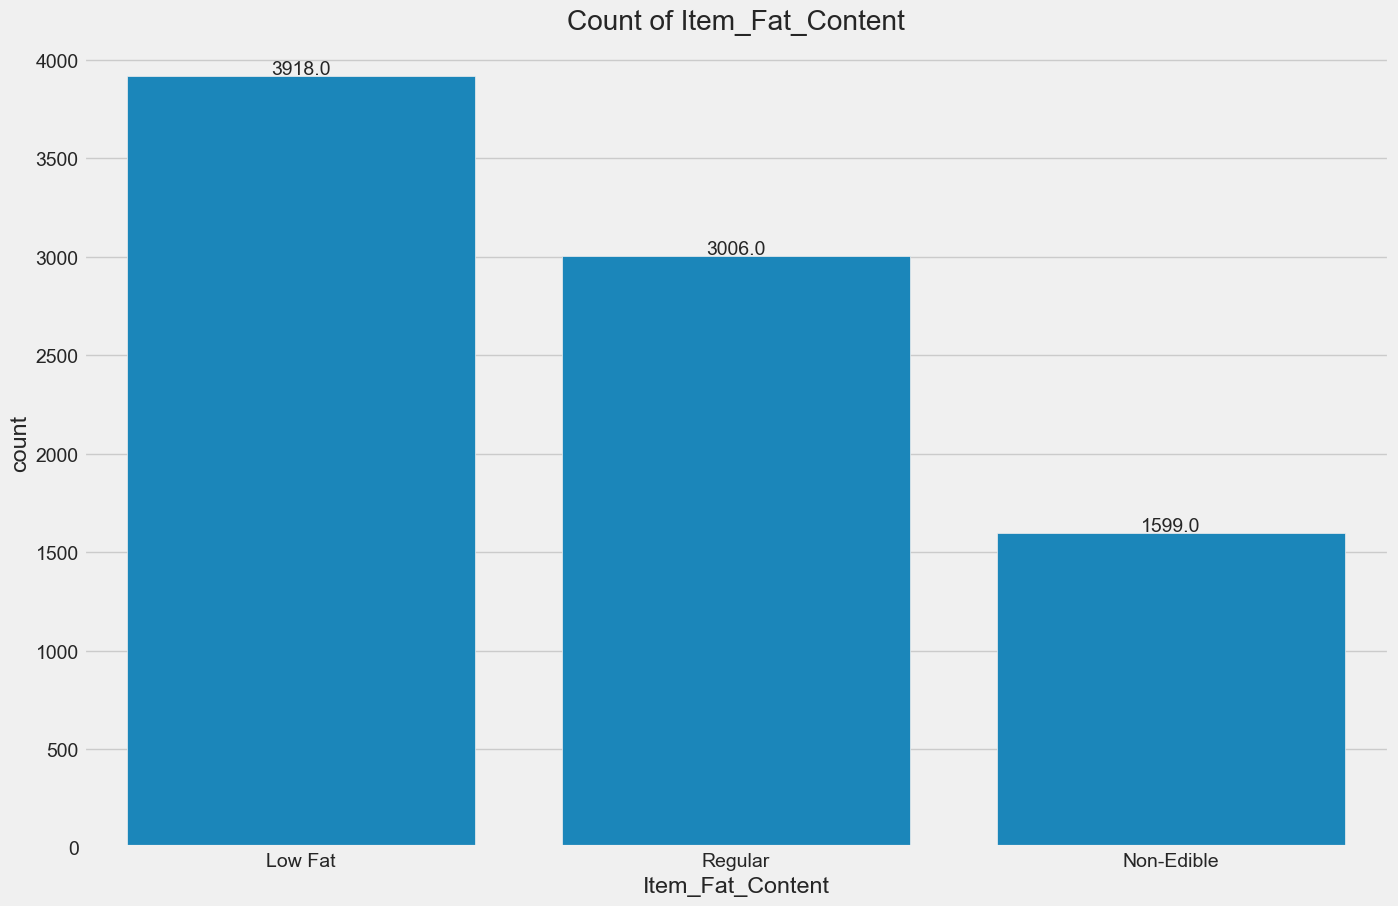

In [39]:
plt.rcParams['figure.figsize'] = 15,10
plt.style.use('fivethirtyeight')
plot = sns.countplot(x = df['Item_Fat_Content'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Item_Fat_Content')
plt.savefig('Count of Item_Fat_Content.png')
plt.show()

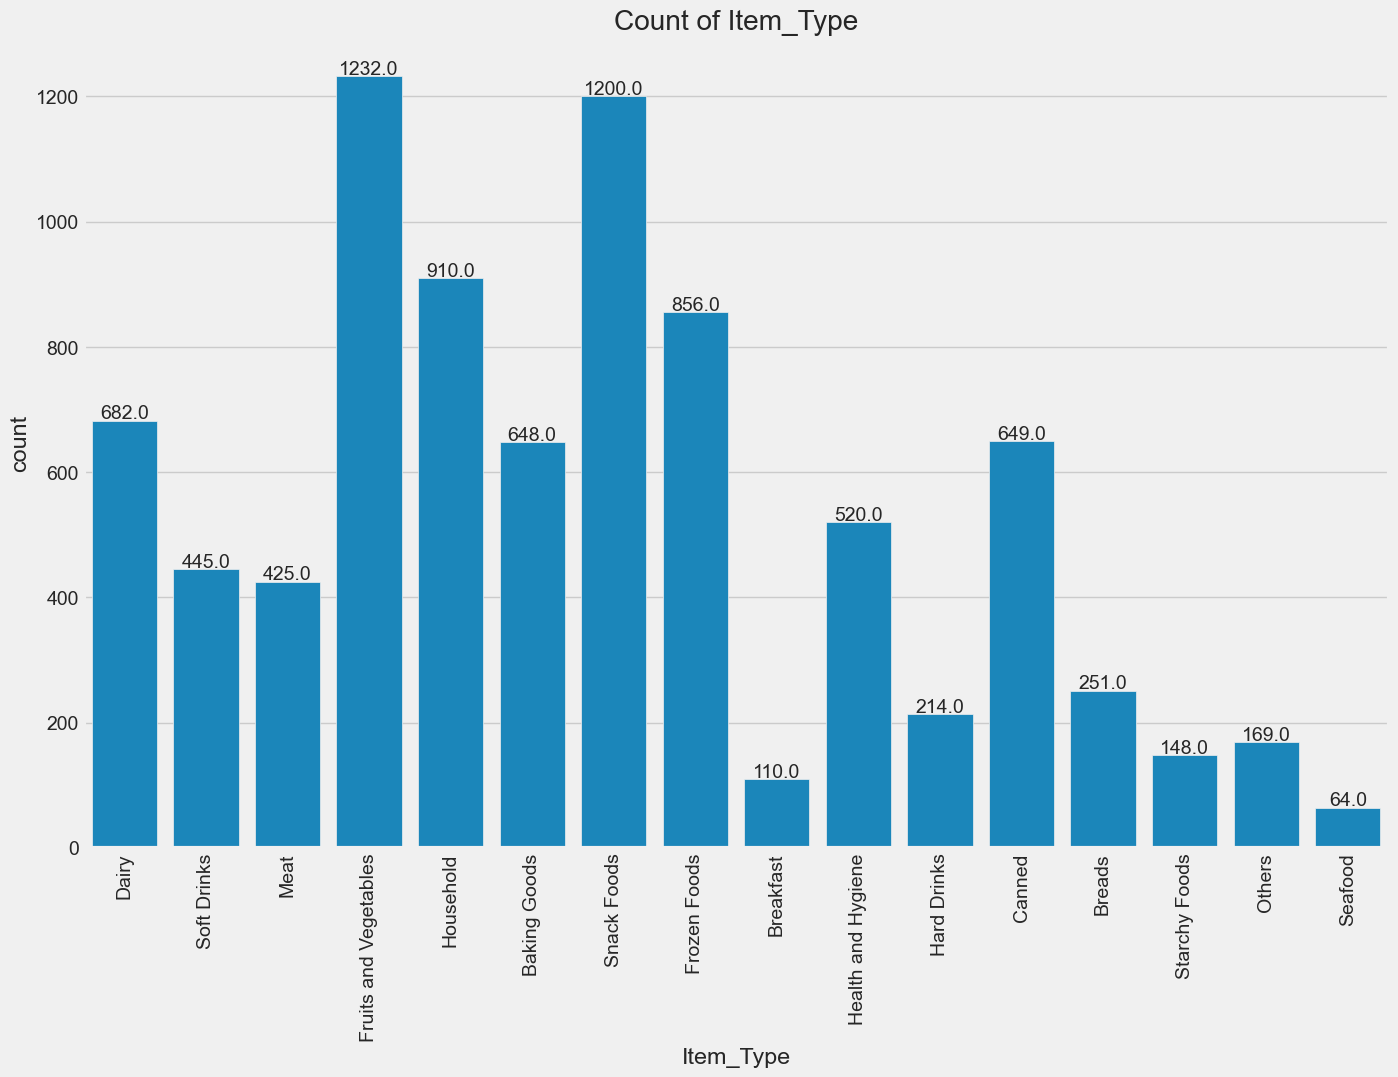

In [40]:
plot = sns.countplot(x = df['Item_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.xticks(rotation = 90)
plt.title('Count of Item_Type')
plt.savefig('Count of Item_Type.png')
plt.show()

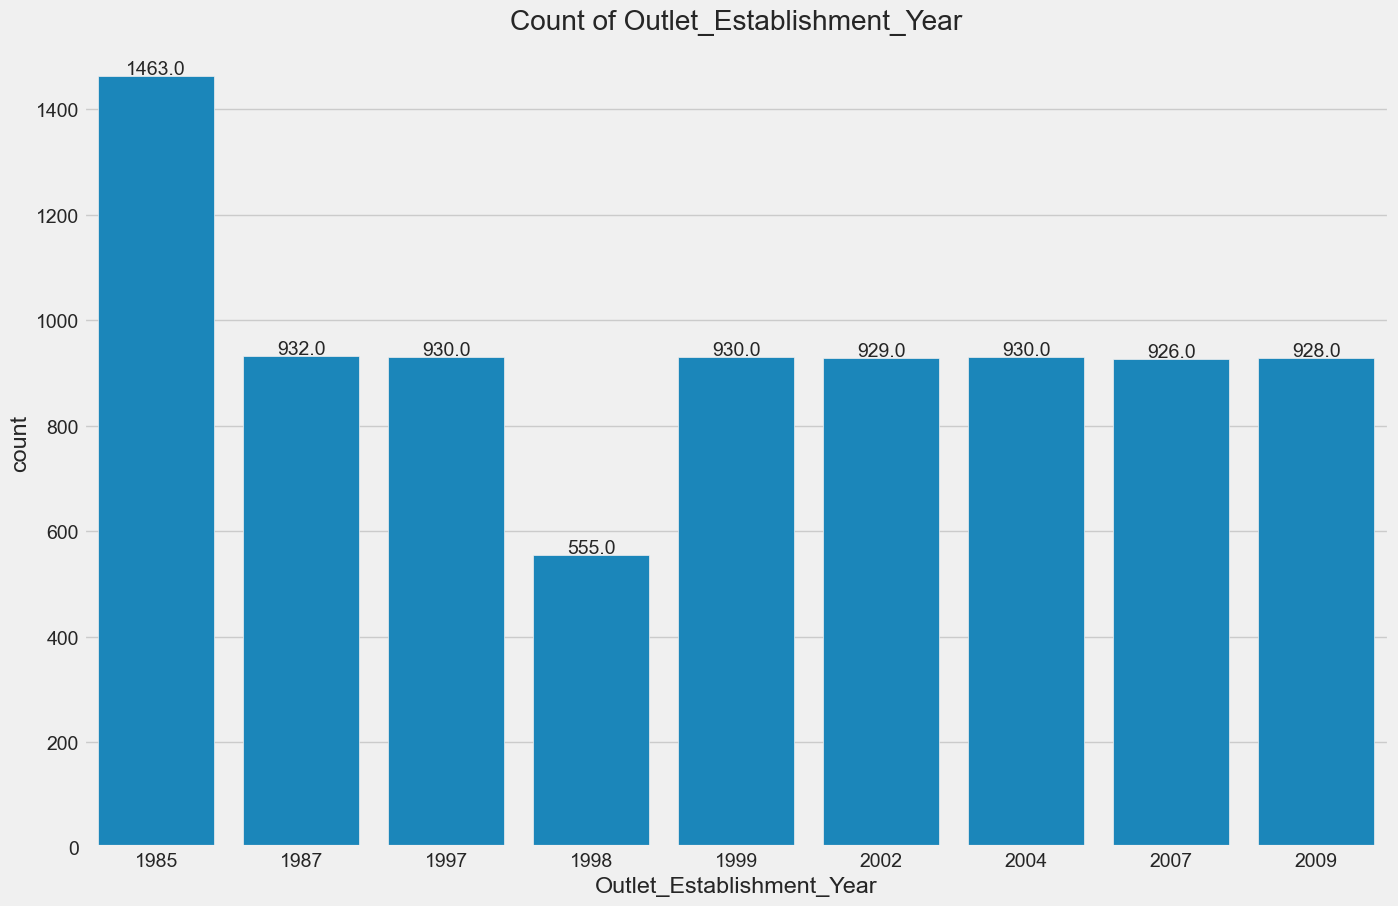

In [41]:
plot = sns.countplot(x = df['Outlet_Establishment_Year'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Establishment_Year')
plt.savefig('Count of Outlet_Establishment_Year.png')
plt.show()

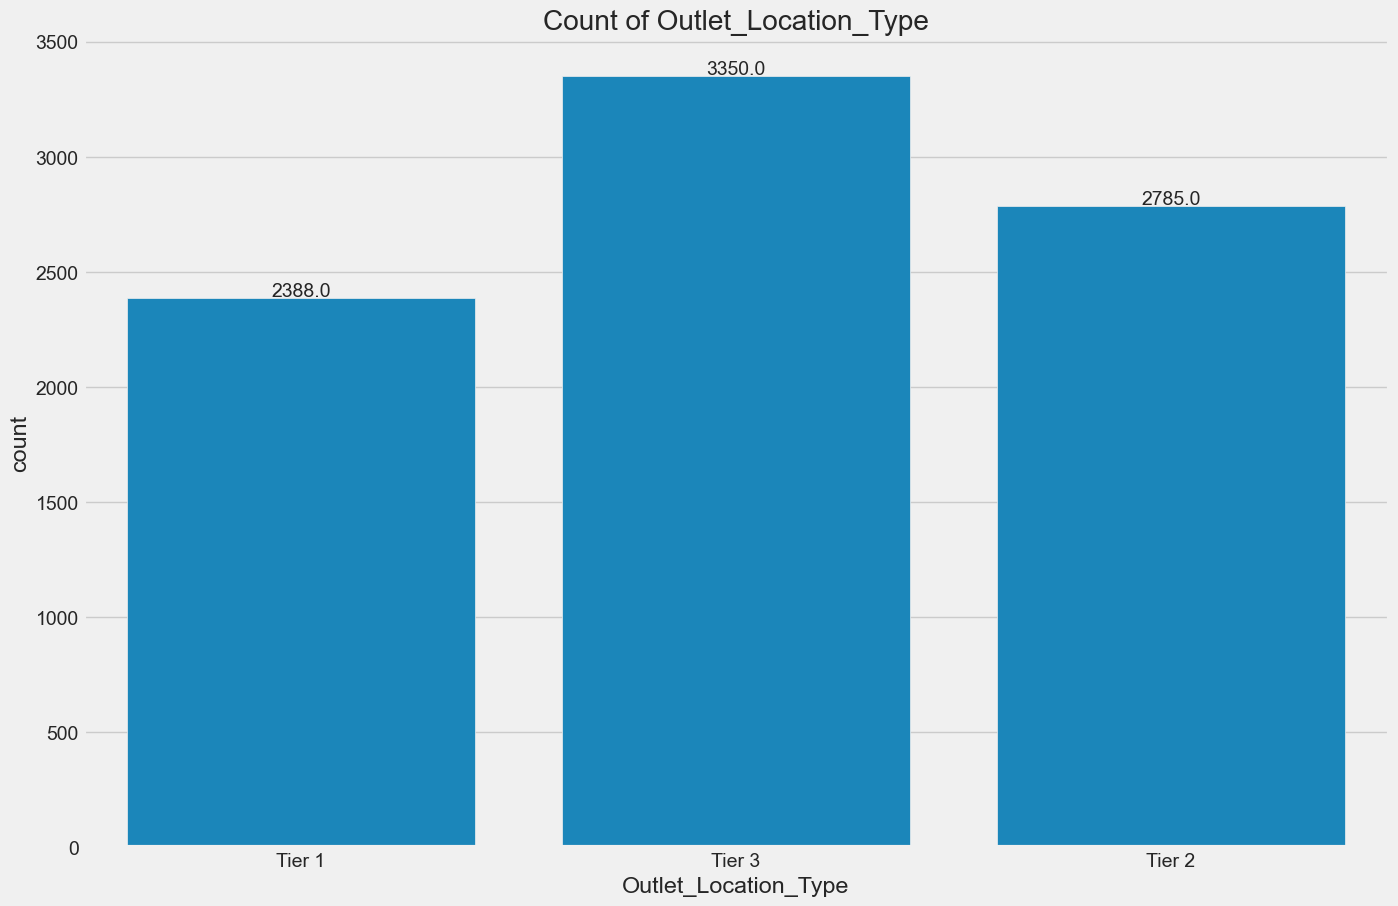

In [42]:
plot = sns.countplot(x = df['Outlet_Location_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Location_Type')
plt.savefig('Count of Outlet_Location_Type.png')
plt.show()

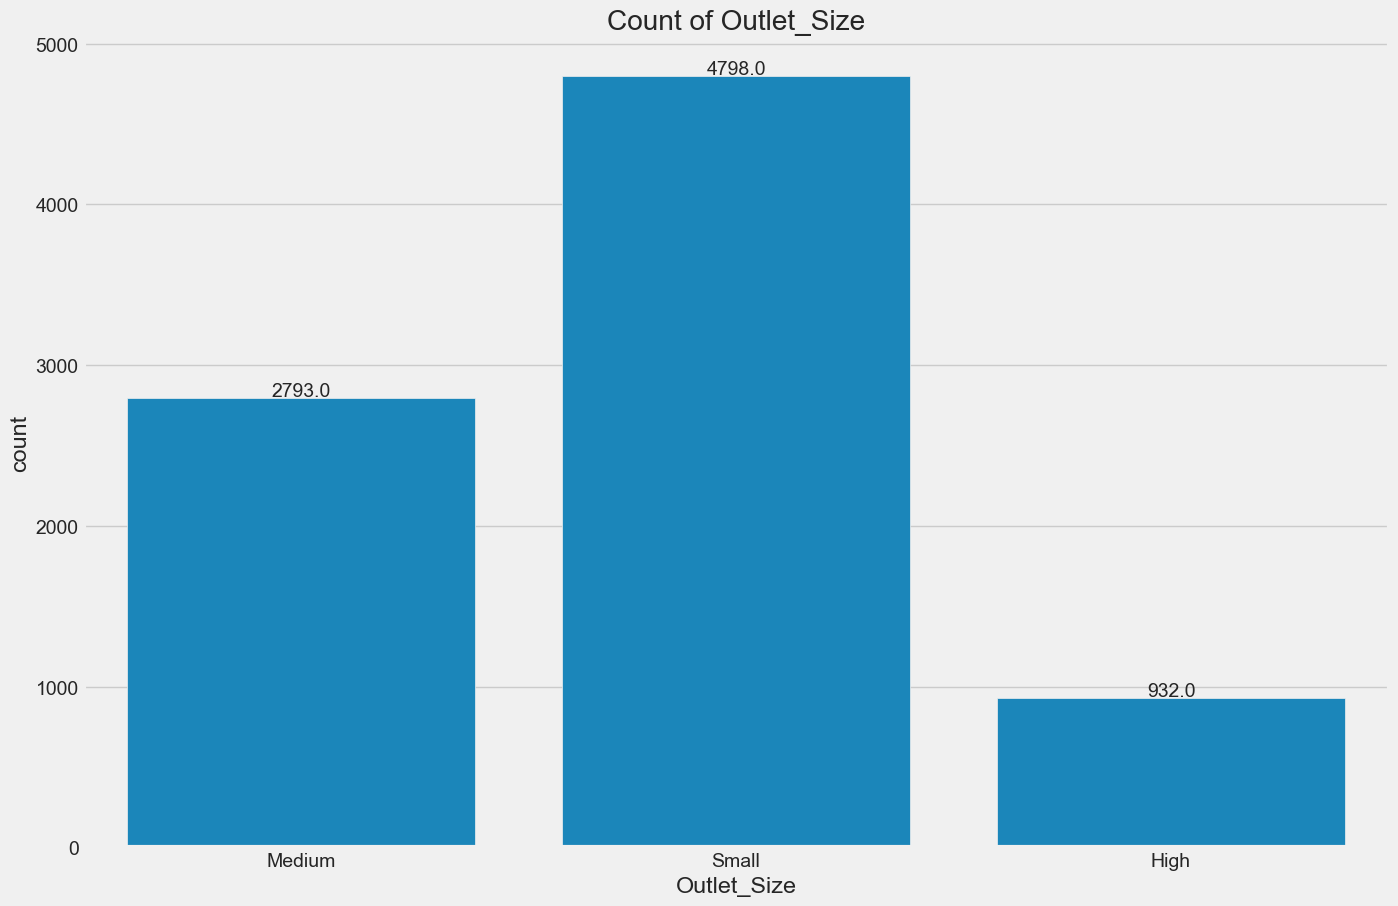

In [44]:
plot = sns.countplot(x = df['Outlet_Size'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Size')
plt.savefig('Count of Outlet_Size.png')
plt.show()

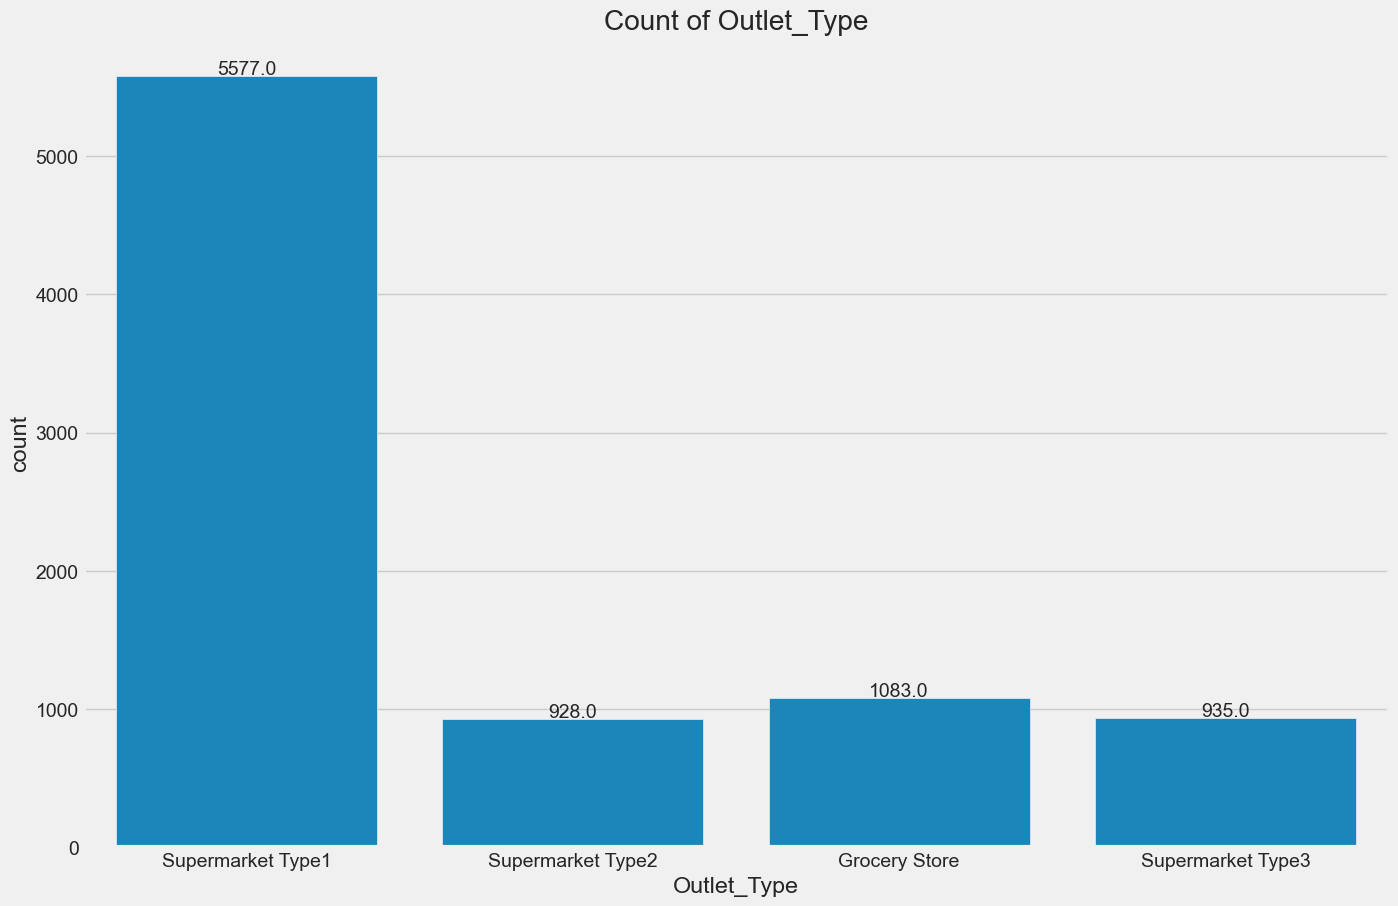

In [45]:
plot = sns.countplot(x = df['Outlet_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Type')
plt.savefig('Count of Outlet_Type.png')
plt.show()

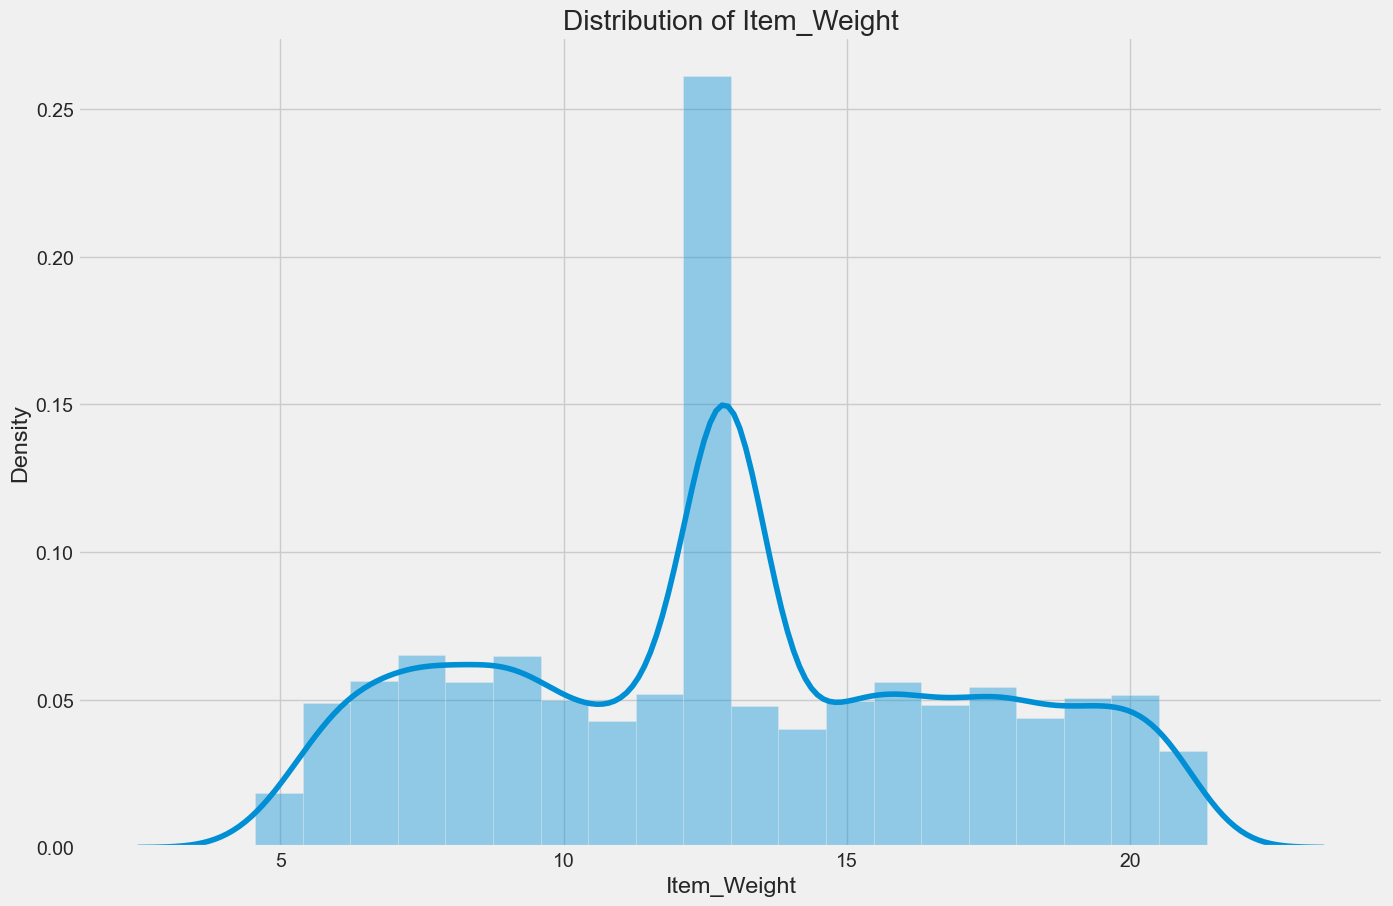

In [46]:
sns.distplot(df['Item_Weight'],bins = 20)
plt.title('Distribution of Item_Weight')
plt.savefig('Distribution of Item_Weight.png')
plt.show()

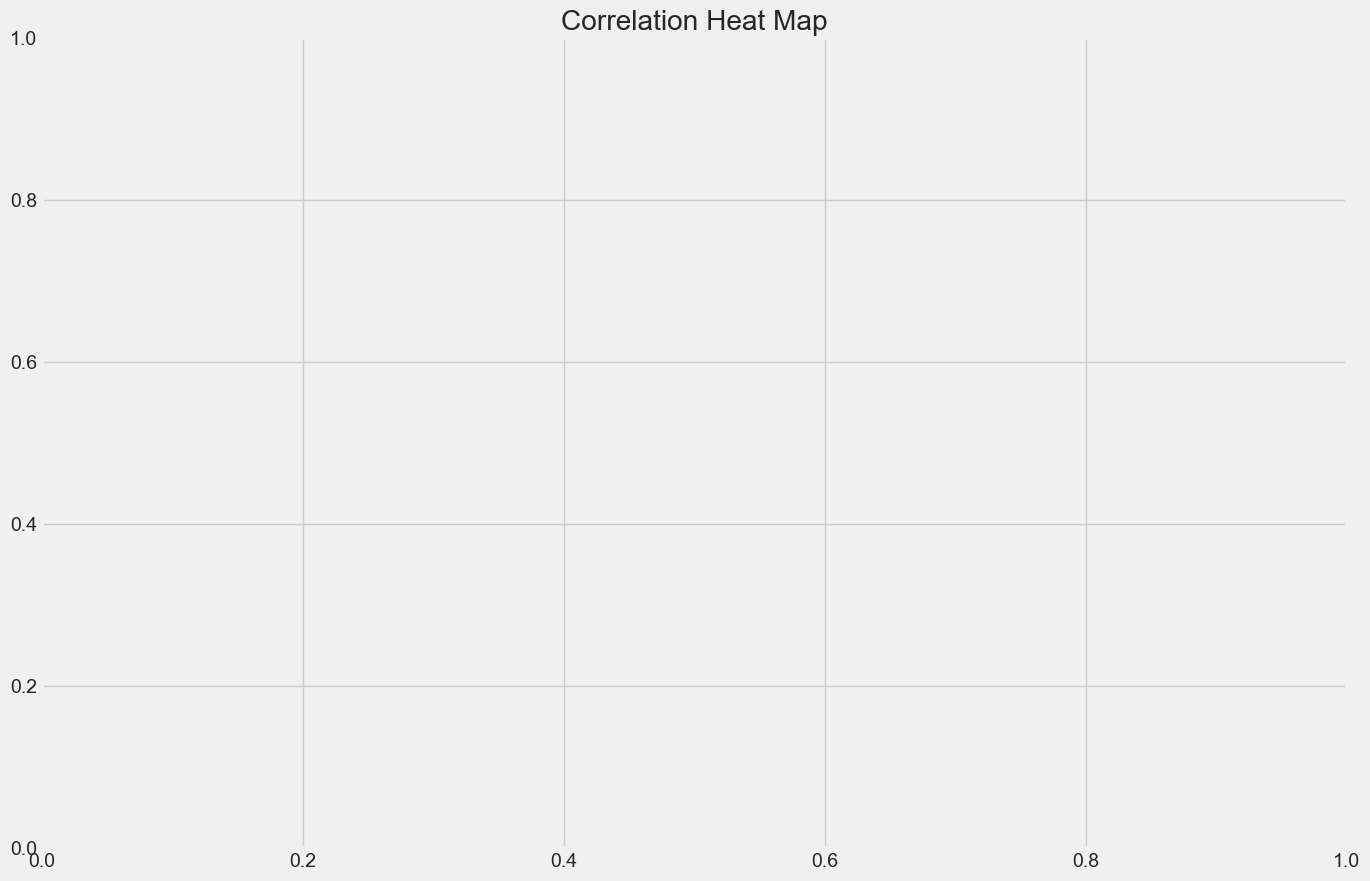

In [51]:

plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

In [53]:
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])

In [54]:
df.dtypes


Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
New_Item_Type                 object
Outlet_Years                   int64
Outlet                         int64
dtype: object

In [55]:
cat_col = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type']
for col in cat_col:
    df[col] = le.fit_transform(df[col])

In [56]:
df = pd.get_dummies(df,columns = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type'])


In [57]:
x = df.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year','Item_Outlet_Sales'],axis=1)
y=df['Item_Outlet_Sales']

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)


In [59]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model,x,y,scoring = 'neg_mean_squared_error', cv = 10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score,'\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ',cv_score)
    cv_score = cross_val_score(model, x, y, cv = 10)
    print()
    print('R2 Score')
    print(cv_score,'\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ',cv_score,'\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ',r2_score(y,pred),'\n')
    coef = pd.Series(model.coef_, x.columns).sort_values()
    print (coef)
    coef.plot(kind='bar', title="Model Coefficients")
    plt.show()

In [64]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model,x,y,scoring = 'neg_mean_squared_error', cv = 10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score,'\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ',cv_score)
    cv_score = cross_val_score(model, x, y, cv = 10)
    print()
    print('R2 Score')
    print(cv_score,'\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ',cv_score,'\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ',r2_score(y,pred),'\n')
    coef = pd.Series(model.feature_importances_, x.columns).sort_values(ascending=False)
    coef.plot(kind='bar', title="Feature Importance")
    plt.show()

Model Report : 

Scoring - neg_mean_squared_error
[-2614574.94274808 -2314285.0659479  -2472375.51634616 -2297035.31985095
 -2439197.65026104 -2717614.42892021 -2475168.38206891 -2352314.67100668
 -2074562.86721552 -2242386.75702314] 

Absolute Average of neg_mean_squared_error :  2399951.5601388616

R2 Score
[ 0.10668969  0.1511286   0.20072663  0.33068395  0.22495313 -0.00318621
  0.19973614  0.17068599  0.28005224  0.17355946] 

Average R2 Score :  0.18350296194703036 

Accuracy for Full Data :
R2 Score :  1.0 



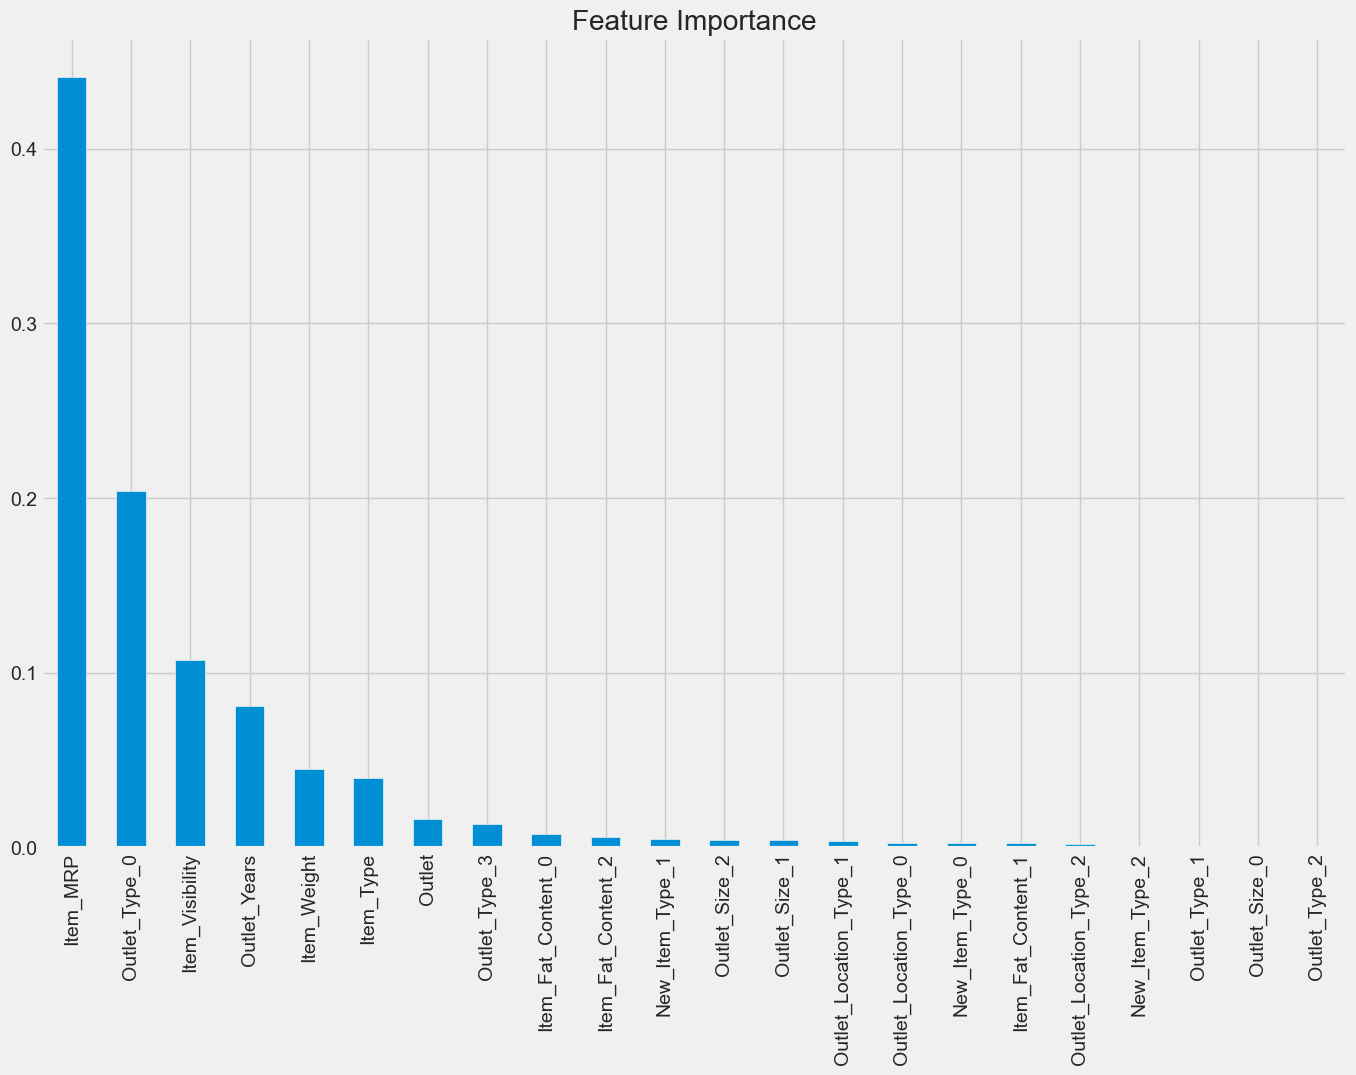

In [65]:
model = DecisionTreeRegressor()
train(model, x_train, y_train)

Model Report : 

Scoring - neg_mean_squared_error
[-1267556.87181714 -1352571.34155268 -1282160.50806527 -1344157.82668096
 -1237730.31780584 -1441951.13205532 -1173650.23651272 -1444036.8035777
 -1103922.92853505 -1381337.91349742] 

Absolute Average of neg_mean_squared_error :  1302907.5880100105

R2 Score
[0.56931844 0.54729056 0.58346304 0.58030105 0.60620627 0.46943654
 0.585855   0.47742129 0.59028592 0.50488546] 

Average R2 Score :  0.5514463569987725 

Accuracy for Full Data :
R2 Score :  0.9379047312905974 



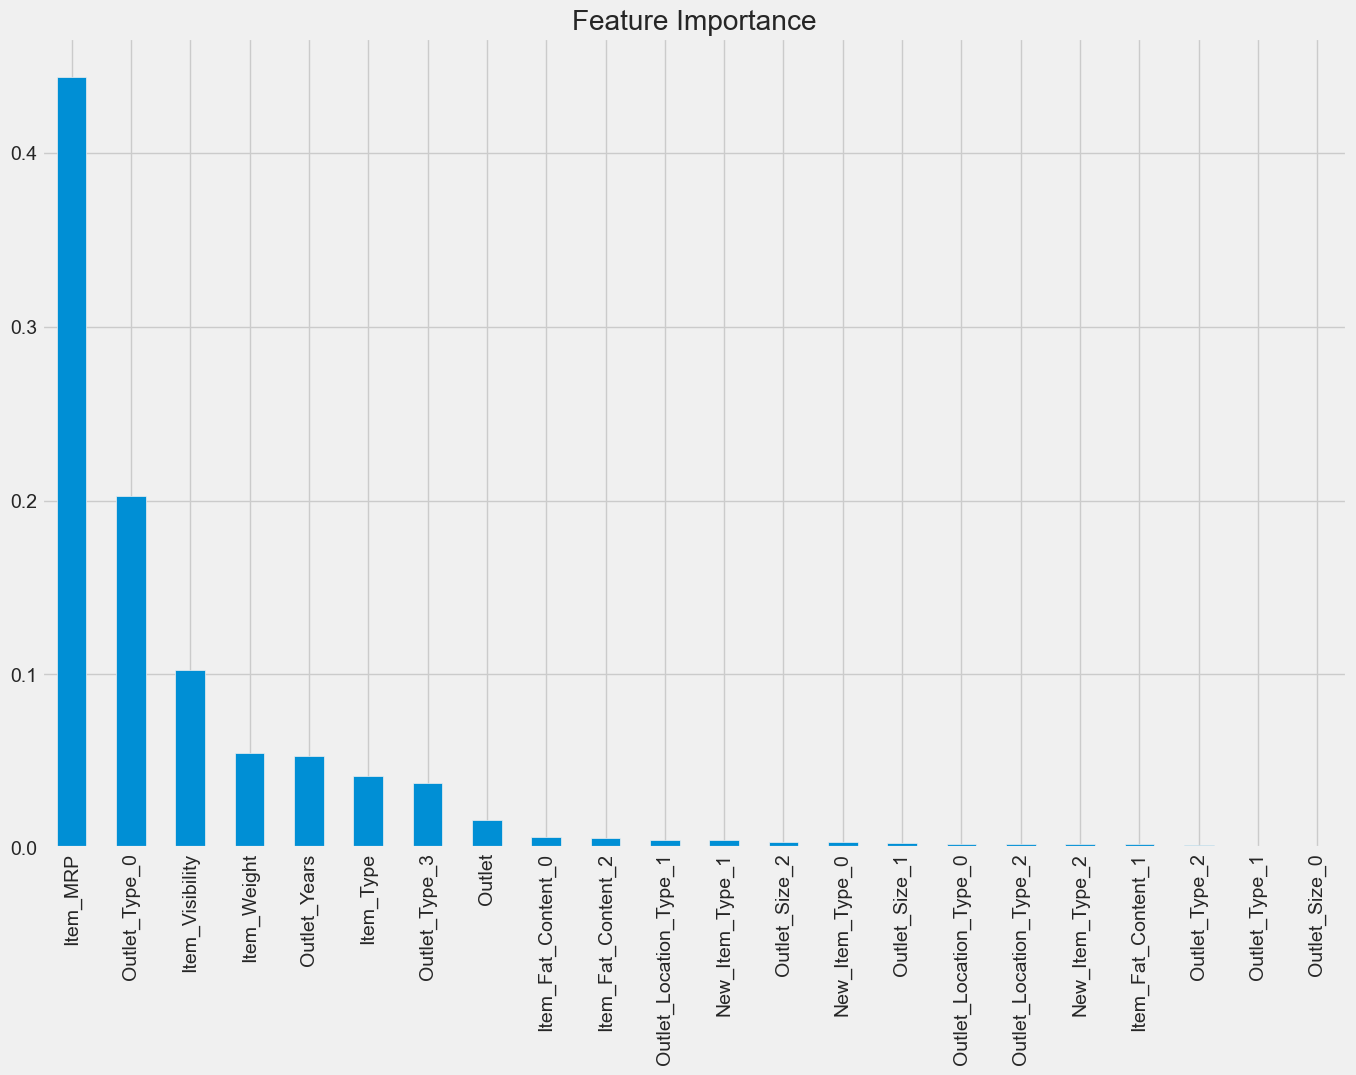

In [66]:
model = RandomForestRegressor()
train(model, x_train, y_train)

Model Report : 

Scoring - neg_mean_squared_error
[-1373362.69470226 -1394656.76410402 -1416803.09438707 -1414900.6899943
 -1342070.94061001 -1524846.49217957 -1254160.04913474 -1529622.21467006
 -1199975.91923701 -1437362.02855727] 

Absolute Average of neg_mean_squared_error :  1388776.088757632

R2 Score
[0.51005078 0.51152447 0.52542049 0.55358962 0.58016978 0.44147738
 0.56384791 0.46079805 0.55641633 0.49186953] 

Average R2 Score :  0.5195164327726903 

Accuracy for Full Data :
R2 Score :  0.9999997066433858 



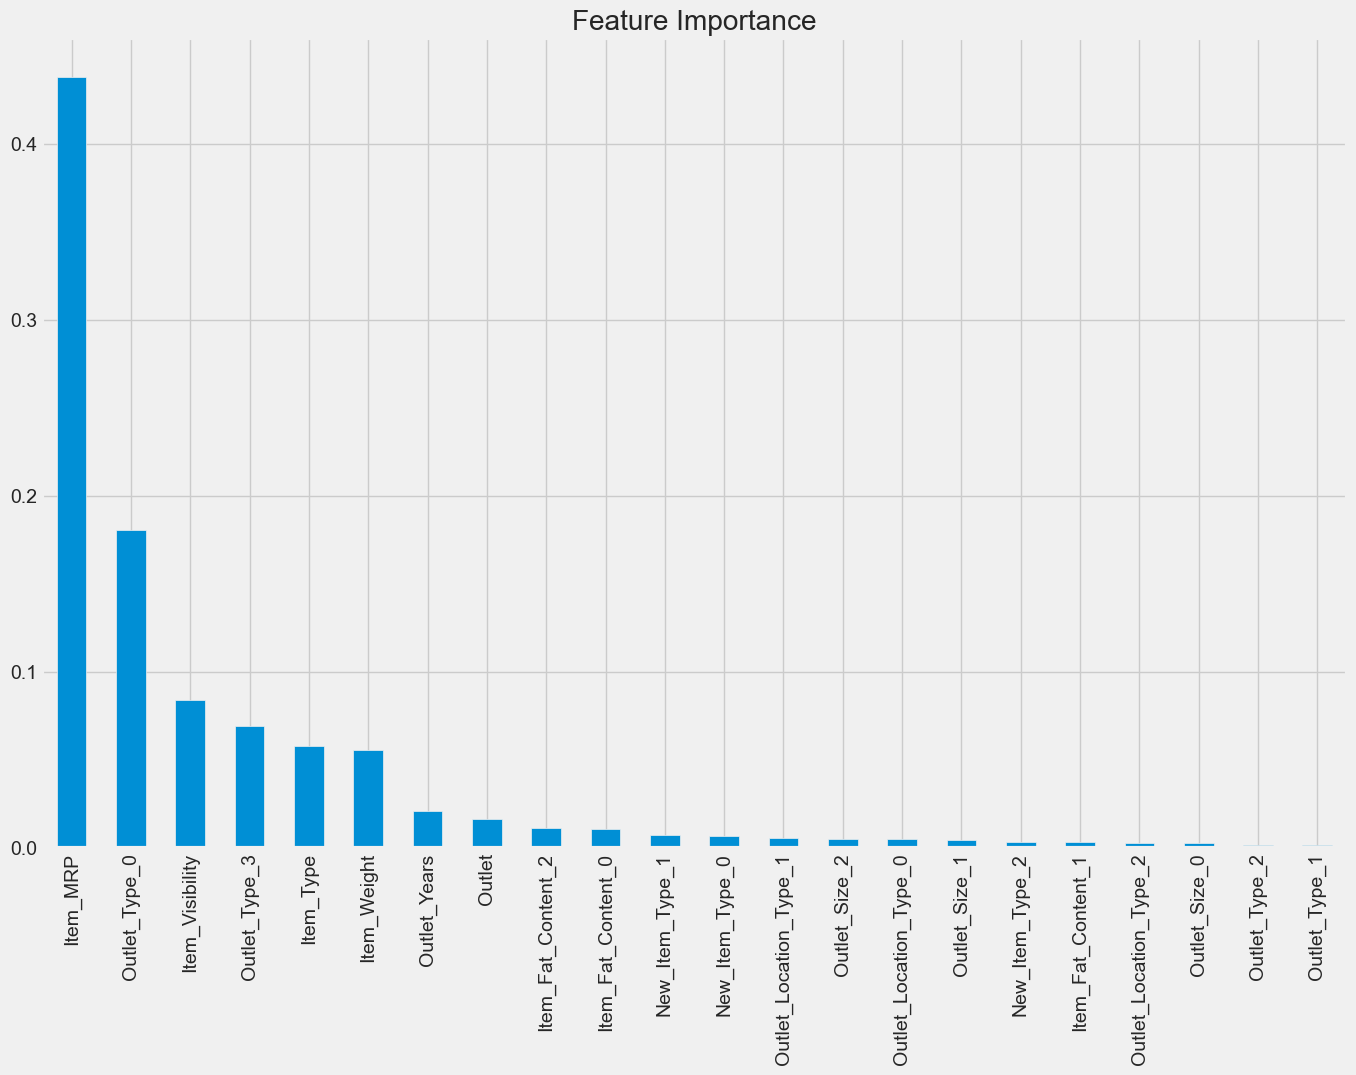

In [67]:
model = ExtraTreesRegressor()
train(model, x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 22
[LightGBM] [Info] Start training from score 2177.083082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 22
[LightGBM] [Info] Start training from score 2176.346306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

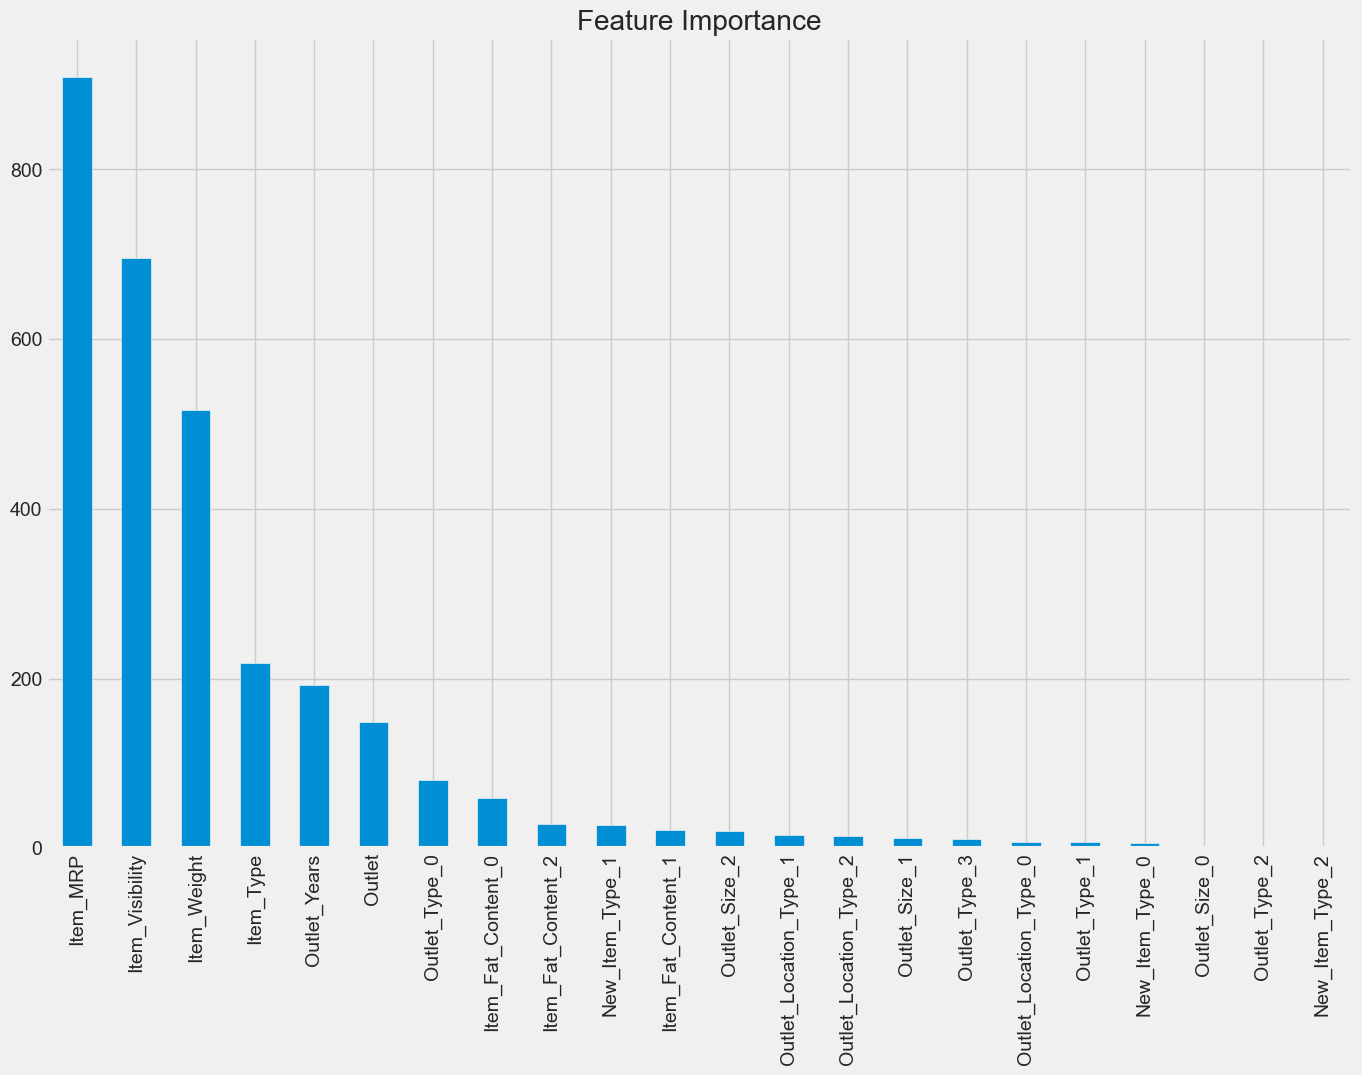

In [68]:
model = LGBMRegressor()
train(model, x_train, y_train)

Model Report : 

Scoring - neg_mean_squared_error
[-1392715.32380723 -1424357.19566994 -1399930.63393958 -1474098.57736987
 -1272857.00693838 -1535221.60193307 -1248727.98807695 -1568092.2770916
 -1257647.67239362 -1538944.46818014] 

Absolute Average of neg_mean_squared_error :  1411259.274540039

R2 Score
[0.51344694 0.5093663  0.53895295 0.54384627 0.60228115 0.43566206
 0.56530552 0.43519923 0.53514158 0.44674388] 

Average R2 Score :  0.5125945875160611 

Accuracy for Full Data :
R2 Score :  0.8819933050973913 



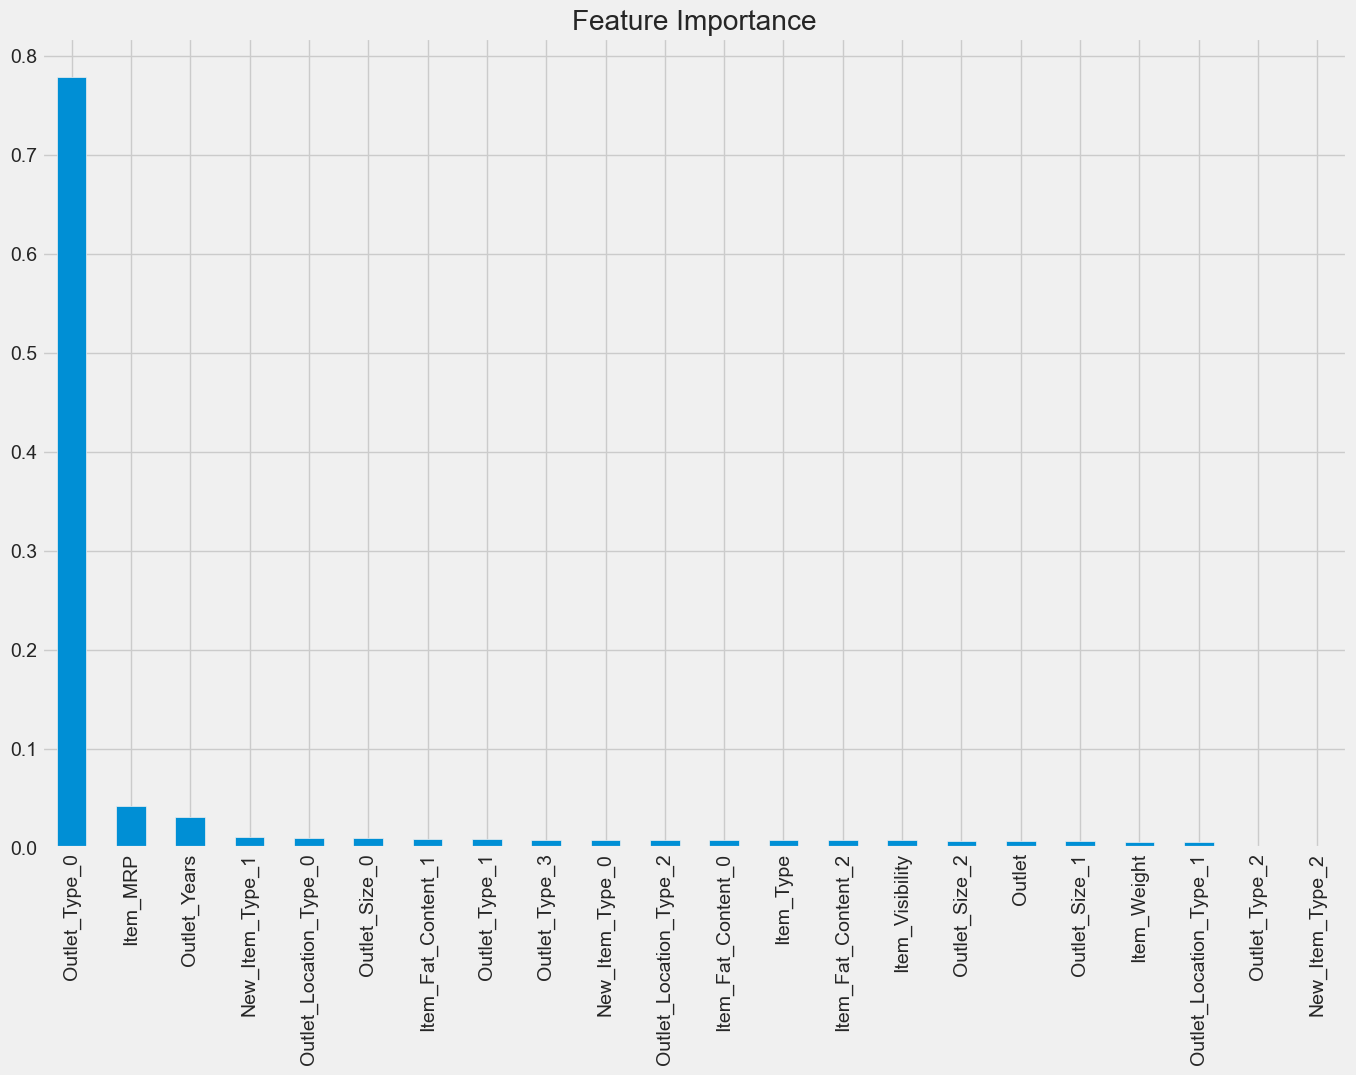

In [69]:
model = XGBRegressor()
train(model, x_train, y_train)

Model Report : 

Scoring - neg_mean_squared_error
[-1204342.95001023 -1258326.80109096 -1236189.83533822 -1305120.10336832
 -1133897.68095895 -1358844.46809349 -1125484.0315177  -1338789.18295122
 -1056983.85106778 -1321537.20330976] 

Absolute Average of neg_mean_squared_error :  1233951.6107706637

R2 Score
[0.57925591 0.56655709 0.59287863 0.59613596 0.64570059 0.5004972
 0.60820795 0.51779039 0.60931201 0.52490258] 

Average R2 Score :  0.5741238307892427 

Accuracy for Full Data :
R2 Score :  0.7748063677888094 



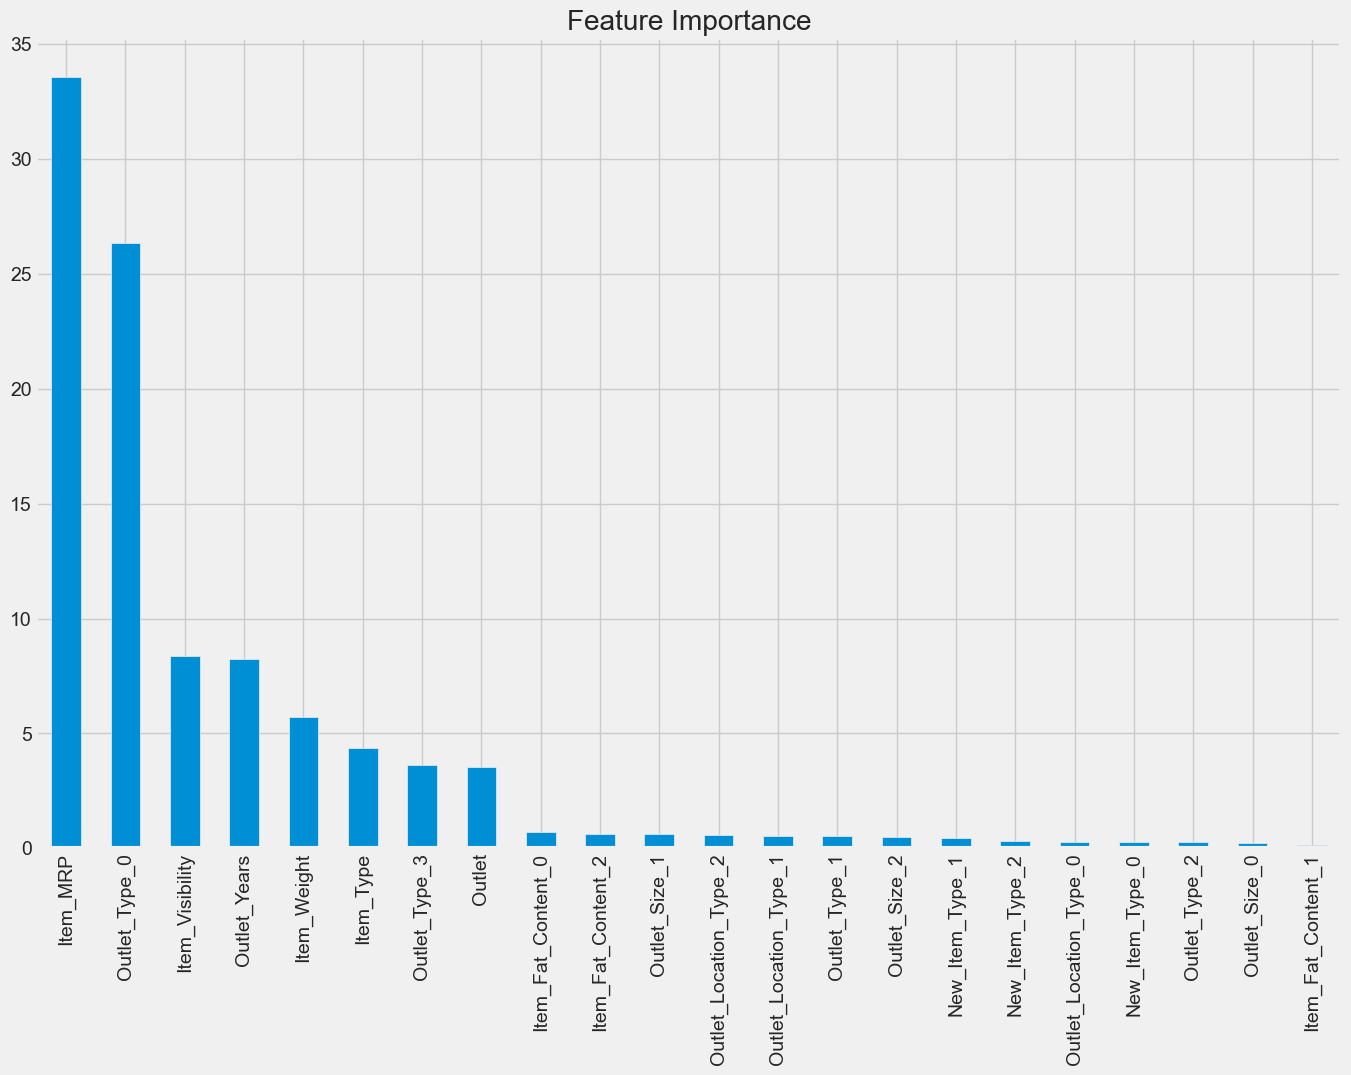

In [70]:
model = CatBoostRegressor(verbose = 0)
train(model, x_train, y_train)

In [71]:
random_grid = {
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
               'min_samples_split':[2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]
}

In [72]:
RF = RandomForestRegressor()
RF = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter =10,
                       verbose = 0, cv =10, random_state = 10, n_jobs = 1)
RF.fit(x_train, y_train)
print('Best Params : ',RF.best_params_,'\n')
print('Best Score : ',RF.best_score_,'\n')
prediction = RF.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15} 

Best Score :  -1220212.167167326 

R2 Score :  0.5731575891642846


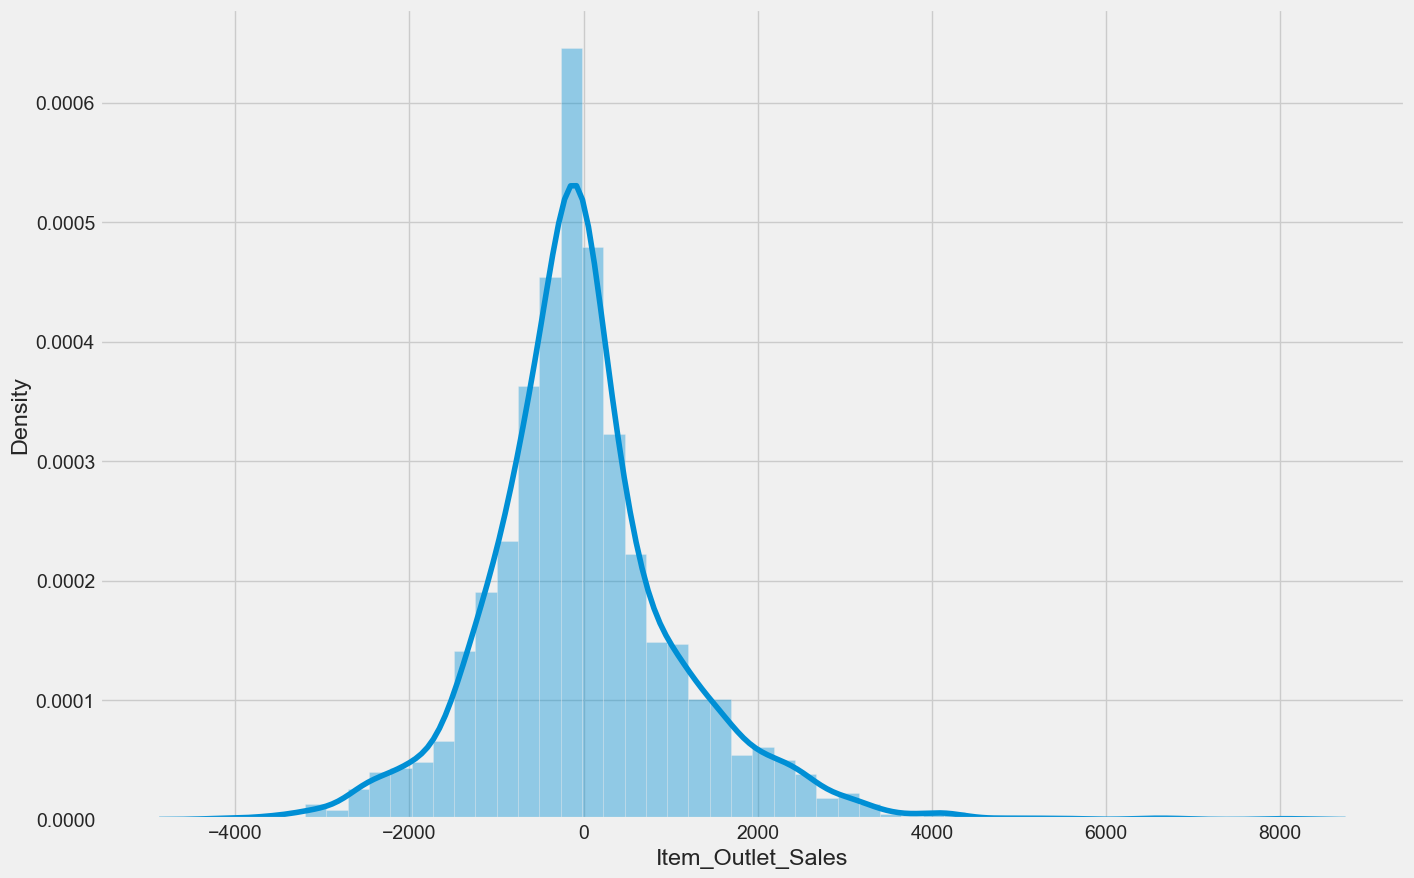

In [73]:
sns.distplot(y_test-prediction)
plt.show()

In [74]:
params = {
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

In [75]:
lgb = LGBMRegressor()
lgb = RandomizedSearchCV(estimator = lgb, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
lgb.fit(x_train,y_train)
print('Best Params : ',lgb.best_params_,'\n')
print('Best Score : ',lgb.best_score_,'\n')
prediction = lgb.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 22
[LightGBM] [Info] Start training from score 2176.346306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

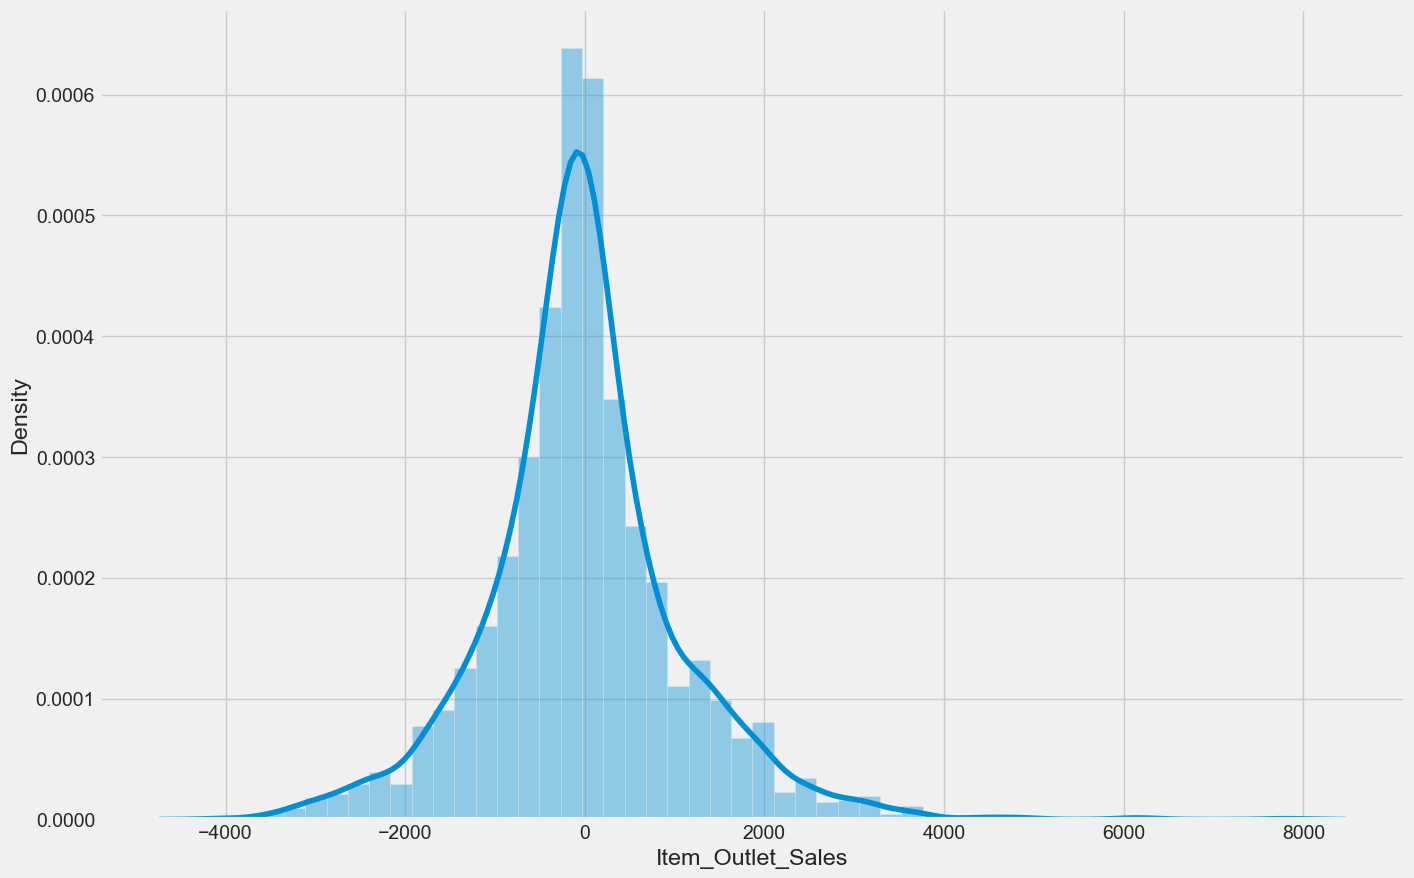

In [76]:
sns.distplot(y_test-prediction)
plt.show()

In [77]:
cat = CatBoostRegressor(learning_rate = 0.08941885942788719, max_depth = 2, n_estimators = 109,
                        subsample = 0.6676443346250142, verbose = 0)
cat.fit(x_train,y_train)
predictions = cat.predict(x_test)
print('R2 score : ',r2_score(y_test,predictions))

R2 score :  0.5976757966600554


In [78]:
pickle.dump(cat,open('Model.pkl','wb'))


In [79]:
model = pickle.load(open('Model.pkl','rb'))
fpred = model.predict(x)
print('R2 Score of Full Data : ',r2_score(y,fpred))

R2 Score of Full Data :  0.6053656226149531
